# Fine-tuning

- 다양한 pretrained networks를 활용한 실험

- <span style='color:red'>주의사항</span>
    - 현재 설치되어있는 cuda 버전이 11.0이라서, 파이토치 1.7.1 버전까지만 설치가 가능하다.
    - cuda 버전을 바꾸어도 될 지 확인해보아야겠다.

In [2]:
from IPython.display import Image

## 실험 1: ResNet-18
- 데이터의 수가 많지 않기 때문에, pretrained된 resnet 18 모델을 활용한다.
- resnet은 imagenet 데이터로 학습되었는데, 대회 데이터인 마스크 데이터셋과는 차이가 있기 때문에
resnet 또한 최적화한다.
- 결과적으로 resnet18을 backbone으로 설정하고, classifier를 basemodel로 만든 뒤 학습시킨다.

```python
# config
{
    "seed": 42,
    "epochs": 20,
    "dataset": "MaskBaseDataset",
    "augmentation": "BaseAugmentation",
    "resize": [
        128,
        96
    ],
    "batch_size": 32,
    "valid_batch_size": 1000,
    "model": "ResNet18",
    "optimizer": "Adam",
    "lr": 0.001,
    "val_ratio": 0.2,
    "criterion": "cross_entropy",
    "lr_decay_step": 20,
    "log_interval": 20,
    "name": "resnet18_test",
}
```

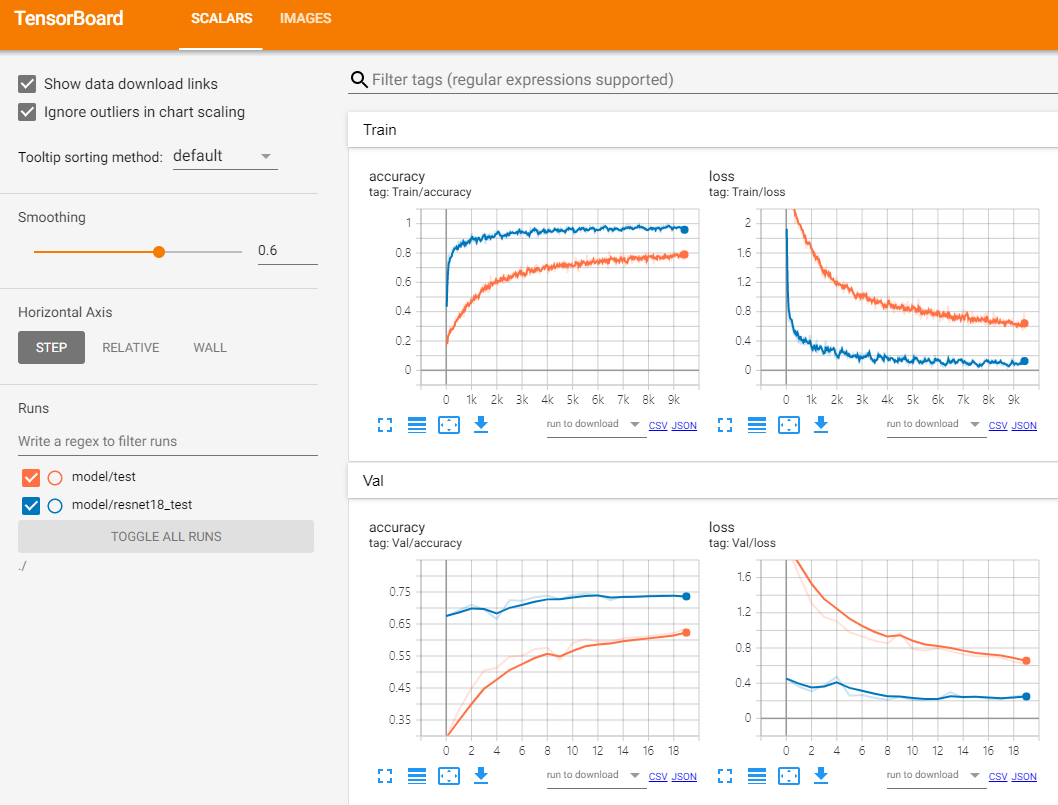

In [3]:
Image(filename="/opt/ml/experiment-results/v3_resnet18.PNG")

**[변경사항]**
- 비교군: baseline_v2의 exp8, resent18
- resnet18의 마지막 fc layer를 1000 -> 18(=num_classes)로 변경하였음.

**[결과]**
- baseline_v2에서 가장 좋은 성능을 보이는 모델과 비교했을 때, validation accuracy 기준 10% 가량의 성능 향상이 나타났다.
- 제출했을 때, test acc 기준 10% 가량의 성능 향상이 나타났다.

**[분석]**
- 우선 데이터의 수가 적기 때문에 resnet18 모델로도 충분한 표현력을 가질 수 있다고 생각했고, baseline_v2와 비교했을 때 꽤나 성능이 향상되었다.
- 다만 training acc와 val acc를 비교했을 때 차이가 심했고, 이는 overfitting을 의심할 수 밖에 없었다.
    - 20 에폭 밖에 돌리지 않았음에도 training acc 기준 95% 까지 달성했고, val acc는 73% 정도 찍혔다.
    - val acc에 비해서 training acc만 비정상적으로 높았던 것을 보아, overfitting이 의심된다.
    - 다만 training data에 overfitting이 일어났던 점은 data의 수가 너무 적었기 때문이라고 생각한다.
    - 또한 training data와 val data를 split할 때, class의 분포는 고려하지 않은 채로 나누었기 때문에 이러한 현상이 심화되었다고 생각한다.
- ImageNet의 모든 데이터를 알 수는 없지만, 사람의 얼굴 혹은 마스크를 착용한 사람의 얼굴 데이터는 거의 없을 것으로 생각한다.
    - 다만 종류가 다른 데이터라고 해도, randomly initialized weight 보다는 pretrained weight가 성능 측면에서 좋기도 하고, 또한 모든 parameters를 tuning했기 때문에 최소한의 성능은 나타난 것으로 보여진다.

**[계획]**
- fold 방식을 이용해서, 학습에 사용할 수 있는 데이터를 최대한 활용하는 방식으로 접근한다.
- train/validation split을 클래스 간 분포가 어느 정도 맞게 분리해본다.